In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gaussian(x, mean, std_dev):
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

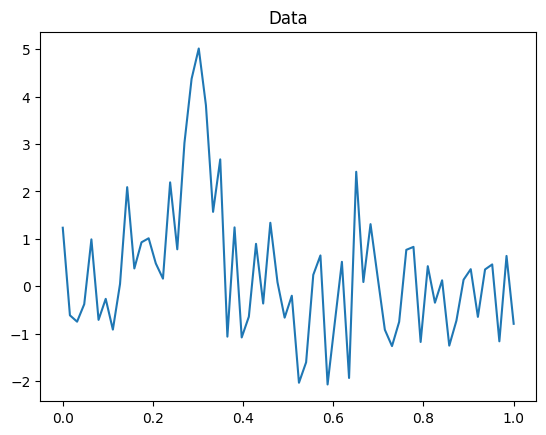

In [4]:
x_data = np.linspace(0, 1, 64)
y_data = gaussian(x_data, 0.3, 0.02)*0.3
y_data += np.random.normal(0, 1, y_data.size)

plt.title("Data")
plt.plot(x_data, y_data)

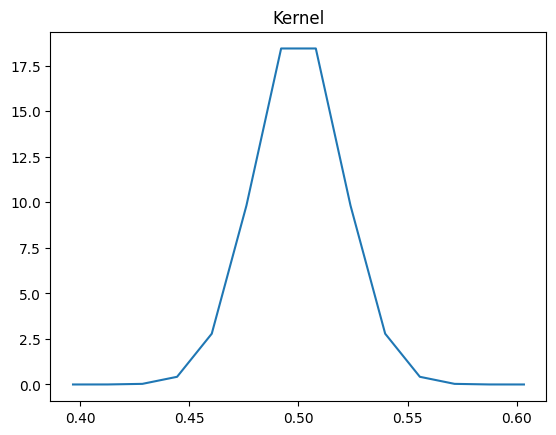

In [5]:
x_kernel = np.linspace(0, 1, 64)[25:-25]
y_kernel = gaussian(x_kernel, 0.5, 0.02)

plt.title("Kernel")
plt.plot(x_kernel, y_kernel)

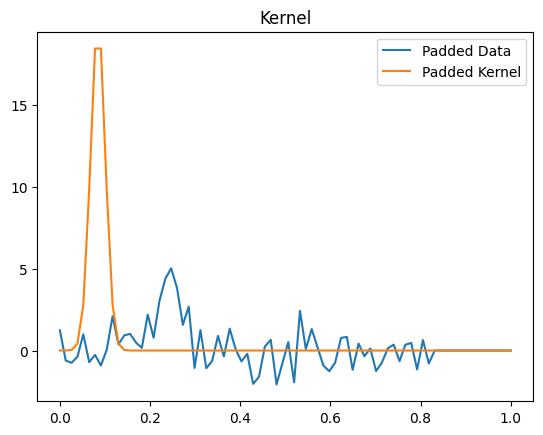

In [6]:
x_pad = np.linspace(0, 1, x_data.size + x_kernel.size*2)
y_data_pad = np.pad(y_data, (0, y_kernel.size*2))
y_kernel_pad = np.pad(y_kernel, (0, y_data.size+y_kernel.size))

x_pad = np.linspace(0, 1, x_data.size + x_kernel.size)
y_data_pad = np.pad(y_data, (0, y_kernel.size))
y_kernel_pad = np.pad(y_kernel, (0, y_data.size))

plt.title("Kernel")
plt.plot(x_pad, y_data_pad, label="Padded Data")
plt.plot(x_pad, y_kernel_pad, label="Padded Kernel")
plt.legend()

/Users/marrewijk/miniconda3_intel/envs/LUV_env/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/marrewijk/miniconda3_intel/envs/LUV_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


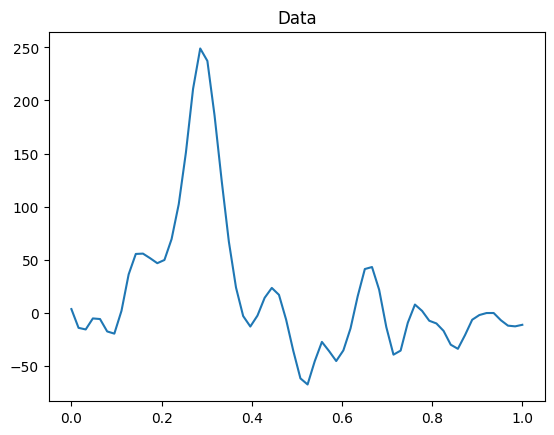

# from chat

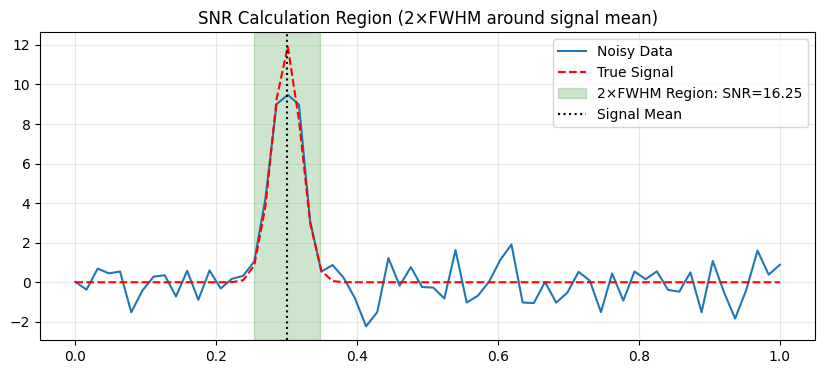

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, mean, std_dev):
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

# Generate data
x_data = np.linspace(0, 1, 64)

# Generate y-data
signal_mean = 0.3
signal_width = 0.02
signal_amplitude = 0.6
noise_std = 0.9

# Create a Gaussian signal
y_true_signal = gaussian(x_data, signal_mean, signal_width) * signal_amplitude
y_data        = y_true_signal + np.random.normal(0, noise_std, x_data.size)

#estimate SNR
fwhm = 2.355 * signal_width 
region_min = signal_mean - fwhm
region_max = signal_mean + fwhm

# Find indices corresponding to this region
region_indices = np.where((x_data >= region_min) & (x_data <= region_max))[0]
measured_flux  = np.sum(y_data[region_indices]) * (x_data[1] - x_data[0])
noise_flux     = len(region_indices)**0.5 * noise_std * (x_data[1] - x_data[0])  

# Calculate SNR in different ways
# 1. True signal flux to noise flux ratio
snr_flux_data = measured_flux / noise_flux
snr_peak_data =  np.max(y_data) / noise_std

# --- SNR using weights (propagated error) ---
# Simulate weights as 1/noise_std^2 for each channel (as in typical radio data)
weights = np.ones_like(y_data) / noise_std**2
# For the region, get the weights
region_weights = weights[region_indices]
# Weighted mean in region (already just sum since weights are equal)
weighted_sum = np.sum(y_data[region_indices] * region_weights)
weighted_sum_err = np.sqrt(np.sum(1.0 / region_weights)) * (x_data[1] - x_data[0])  # error propagation for weighted sum
# SNR using weights
snr_weighted = measured_flux / weighted_sum_err

print(f"SNR (integrated, std-based): {snr_flux_data:.2f}")
print(f"SNR (integrated, weighted error): {snr_weighted:.2f}")

# Visualize the region used for SNR calculation
plt.figure(figsize=(10, 4))
plt.plot(x_data, y_data, label='Noisy Data')
plt.plot(x_data, y_true_signal, 'r--', label='True Signal')
plt.axvspan(region_min, region_max, alpha=0.2, color='green', 
            label=f'2×FWHM Region: SNR={snr_flux_data:.2f}')
plt.axvline(x=signal_mean, color='k', linestyle=':', label='Signal Mean')
plt.title("SNR Calculation Region (2×FWHM around signal mean)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# To do
- project the kernel on the beginning of x_data. 
- correct the padding
- estimate the integrated SNR of the region of the kernel

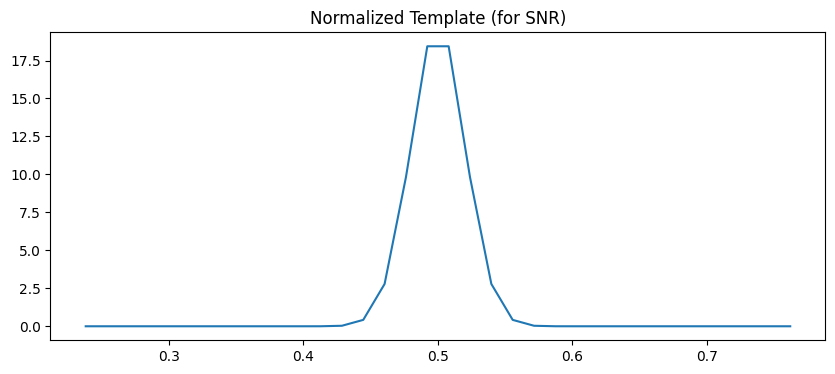

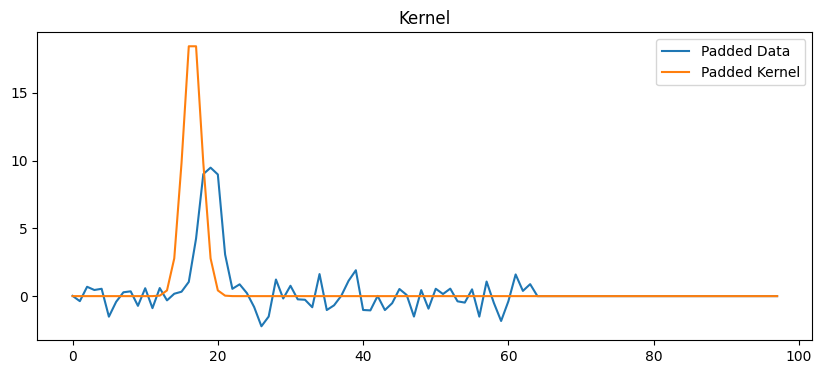

In [4]:
# Create matched filter template
# Note: For optimal detection, template should match the expected signal shape
x_kernel     = np.linspace(0, 1, 64)[15:-15] 
kernel_width = signal_width
kernel_mean  = 0.5
y_kernel     = gaussian(x_kernel, kernel_mean, kernel_width)  # Using different mean to simulate search

#estimate SNR
fwhm = 2.355 * kernel_width 
region_min = kernel_mean - fwhm
region_max = kernel_mean + fwhm

# Find indices corresponding to this region
region_indices = np.where((x_kernel >= region_min) & (x_kernel <= region_max))[0]
measured_flux_kernel = np.sum(y_kernel[region_indices]) * (x_kernel[1] - x_kernel[0])  # Approximate integral using trapezoidal rule

plt.figure(figsize=(10, 4))
plt.title("Normalized Template (for SNR)")
plt.plot(x_kernel, y_kernel)
plt.show()

# Prepare signals for FFT (padding)
y_data_pad = np.pad(y_data, (0, y_kernel.size))
y_kernel_pad = np.pad(y_kernel, (0,  y_data.size ))

plt.figure(figsize=(10, 4))
plt.title("Kernel")
plt.plot(y_data_pad, label="Padded Data")
plt.plot(y_kernel_pad, label="Padded Kernel")
plt.legend()
plt.show()


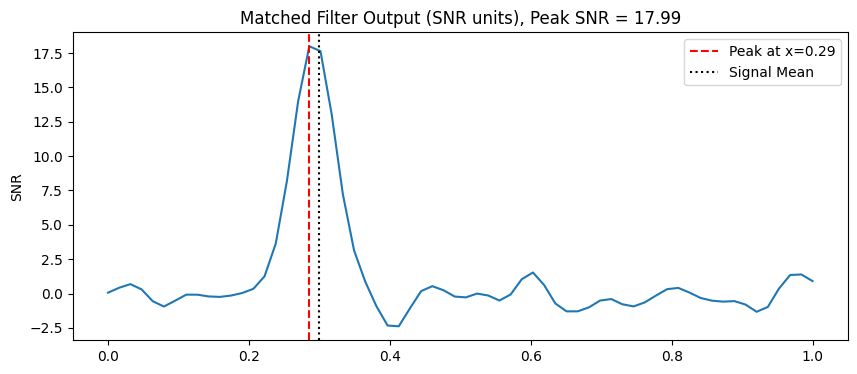

Peak SNR:                             10.53
Integrated SNR:                       16.25
Peak SNR from matched filter:         17.99
Ratio of integrated SNR to peak SNR from matched filter: 0.90


In [5]:
y_kernel_pad_normalized = y_kernel_pad / noise_std**2 / ((y_kernel_pad @ (y_kernel_pad/noise_std**2)))**0.5 # seems to be a bit biased high!!!!! by like a factor of 0.9
y_data_pad_normalized = y_data_pad 

y_kernel_ft = np.fft.fft(y_kernel_pad_normalized)
y_data_ft   = np.fft.fft(y_data_pad_normalized)

# Compute matched filter output
matched_filter_output = np.fft.ifft(y_data_ft * y_kernel_ft)
matched_filter_output = np.real(matched_filter_output[len(y_kernel)//2:-len(y_kernel)//2])  
# Find peak location (most likely signal position)
peak_idx = np.argmax(matched_filter_output)
peak_position = x_data[peak_idx]
peak_snr = matched_filter_output[peak_idx]

plt.figure(figsize=(10, 4))
plt.title(f"Matched Filter Output (SNR units), Peak SNR = {peak_snr:.2f}")
plt.plot(x_data, matched_filter_output)
plt.axvline(x=peak_position, color='r', linestyle='--', label=f'Peak at x={peak_position:.2f}')
plt.axvline(x=signal_mean, color='k', linestyle=':', label='Signal Mean')
plt.ylabel('SNR')
plt.legend()
plt.show()

print(f"{'Peak SNR:':32} {snr_peak_data:10.2f}")
print(f"{'Integrated SNR:':32} {snr_flux_data:10.2f}")
print(f"{'Peak SNR from matched filter:':32} {peak_snr:10.2f}")
print(f"Ratio of integrated SNR to peak SNR from matched filter: {snr_flux_data/peak_snr:.2f}")

In [6]:
(y_kernel_pad @ (y_kernel_pad/noise_std**2))**0.5

np.float64(33.121518044160055)

In [7]:
np.sum(y_kernel), 1/(x_data[1]-x_data[0]), 1/(np.sum(y_kernel))

(np.float64(62.999999999996945),
 np.float64(63.0),
 np.float64(0.015873015873016642))

In [8]:
1/np.amax(y_kernel)

np.float64(0.054239314460054894)